# Import the Packages and Survey Data

In [2]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Necessary Functions

In [171]:
# Necessary Functions
def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

def db_with_limits(data, limit_low=-75, limit_high=0): # Function for numpy arrays
    data = db(data)
    data[data>limit_high] = limit_high
    data[data<limit_low] = limit_low
    return data

def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

# Example Illustration for a patch - Echogram, annotations, Background Sv Distribution
def examp_illustr(survey, x, y, fig_start=-75, fig_finish=5, s_bin=5, db_w_limit=True, patch_size=[256, 256]):
    
    c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=True)
    if db_w_limit:
        a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                    return_numpy=False, frequencies=[38000]))
        echo = a[0,:,:].values
        bg = a[0].values[np.logical_or(c==-1, c==0)] # Background
        
    else:
        a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                  idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                  return_numpy=False, frequencies=[38000])
        echo = db(a[0,:,:].values)
        bg = db(a[0].values[np.logical_or(c==-1, c==0)]) # Background             
        
        
        
    print('mean background Sv =', bg.mean(), ' median background Sv =', np.median(bg))
    print('mean Sandeel Sv =', a[0].values[c==27].mean(), ' median Sandeel Sv =', np.median(a[0].values[c==27]))
    # Echogram Plot
    plt.figure(figsize = (12,12))
    plt.suptitle('Patch Visualization at x='+str(x)+' and y='+str(y))
    
    plt.subplot(2,2,1)
    plt.title('Echogram')
    plt.imshow(echo.T)
    plt.colorbar()
    
    # Annotation Plot
    plt.subplot(2,2,3)
    plt.title('Annotations')
    plt.imshow(c.T)
    plt.colorbar()
        
    # Background Histogram Plot
    plt.subplot(2,2,2)
    plt.title('Background Sv Histogram')
    plt.hist(bg.flatten(), bins = np.arange(fig_start, fig_finish, s_bin), log = False)
    plt.xlabel('sv')
    plt.ylabel('Counts')
    plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
    plt.axvline(x=np.median(bg), color = 'green', label = 'median')
    plt.axvline(x=np.nanpercentile(bg, 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(bg, 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
        
    # Sandeel Histogram Plot
    plt.subplot(2,2,4)
    plt.title('Sandeel Sv Histogram')
    plt.hist(echo[c==27].flatten(),
             bins = np.arange(fig_start, fig_finish, s_bin), log = False)        
    plt.xlabel('Sv')
    plt.ylabel('Counts')
    plt.axvline(x=(echo[c==27].flatten()).mean(), color = 'red', label = 'Sandeel mean Sv')
    plt.axvline(x=np.median((echo[c==27].flatten())), color = 'orange', label = 'Sandeel median Sv')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
    plt.show()    

# dB Domain - Analyzing the Near Surface Area (Height)

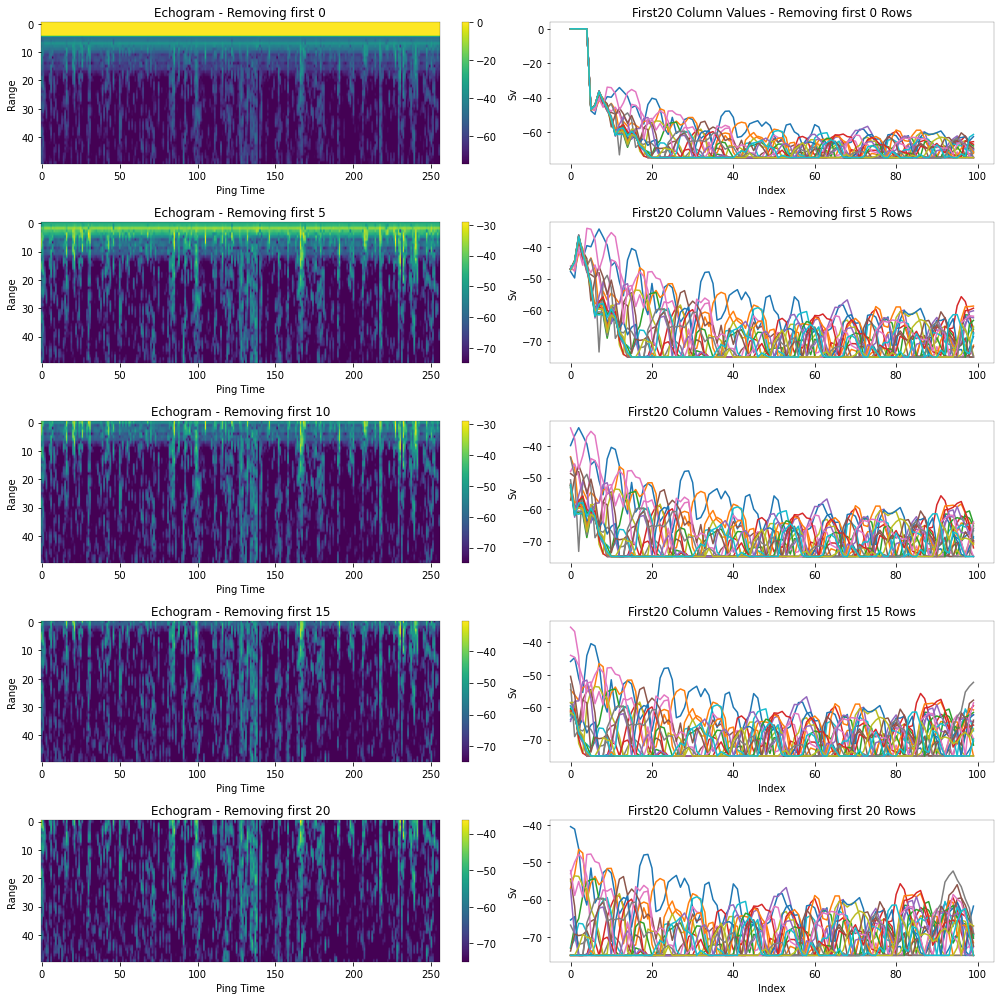

In [176]:
survey = readers[0]
remove_near_surface = [0, 5, 10, 15, 20] # Number of pixels removed vertically from sea surface
plt.figure(figsize = (14,14))
for i in range(len(remove_near_surface)):
    x, y = 46976, 128+remove_near_surface[i] 
    deneme = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=False, frequencies=[38000])
    aa = db_with_limits(deneme[0].values).astype('float64')
    
    # Subplot for echogram
    plt.subplot(len(remove_near_surface),2,2*i+1)
    plt.title('Echogram - Removing first '+str(remove_near_surface[i]))
    plt.imshow(aa.T[0:50], aspect="auto")
    plt.colorbar(fraction=0.05)
    plt.xlabel('Ping Time')
    plt.ylabel('Range')
    
    # Subplot for the Sv Values
    plt.subplot(len(remove_near_surface),2,2*i+2)
    plt.title('First'+str(20)+ ' Column Values - Removing first '+ str(remove_near_surface[i]) + ' Rows')
    for i in range(20):
        plt.plot(aa.T[0:100,i])
    plt.xlabel('Index')
    plt.ylabel('Sv')

    plt.tight_layout()
    

# The Closest Sandeel Pixel to the Sea Surface

In [6]:
# All Acoustic Prediction
import xarray as xr
dd = '/data/2019/S2019847/ACOUSTIC/GRIDDED/S2019847'

sv_fname = dd+'_sv.zarr'
annotations_fname = dd+'_labels.zarr'
schools_fname = dd+'_labels.parquet.csv'

# Open the files
zarr_grid = xr.open_zarr(sv_fname)
zarr_pred = xr.open_zarr(annotations_fname, consolidated = True)
df = pd.read_csv(schools_fname, header=0)

In [7]:
df[df['category']==27].sort_values(by = 'upperdept').head(10) # Sorting Fish School data basedon upperdepth

,ID,object,type,category,proportion,startping,endping,startpingindex,endpingindex,upperdept,lowerdept,upperdeptindex,lowerdeptindex
5546,5547__School-6085,5547,School-6085,27.0,1,2019-05-09 05:08:29.282000,2019-05-09 05:08:32.798000,3099780,3099790,10.108007,9.918057,6,34
5550,5551__School-6086,5551,School-6086,27.0,1,2019-05-09 05:20:48.220000,2019-05-09 05:20:51.376000,3101880,3101889,10.203556,9.823652,6,36
43,44__School-41,44,School-41,27.0,1,2019-04-24 09:13:45.579000,2019-04-24 09:13:57.595000,50952,50964,11.196256,25.842813,30,111
616,617__School-620,617,School-620,27.0,1,2019-04-26 09:33:10.438000,2019-04-26 09:33:21.001000,398384,398414,12.253737,16.784914,23,85
45,46__School-44,46,School-44,27.0,1,2019-04-24 09:25:59.829000,2019-04-24 09:26:24.860000,51605,51627,12.841512,25.706467,29,184
608,609__School-615,609,School-615,27.0,1,2019-04-26 09:31:00.266000,2019-04-26 09:31:03.079000,398014,398022,12.877315,19.893232,27,92
602,603__School-609,603,School-609,27.0,1,2019-04-26 09:06:14.298000,2019-04-26 09:06:22.048000,393790,393812,13.203077,19.528427,29,148
4553,4554__School-5002,4554,School-5002,27.0,1,2019-05-06 05:58:06.657000,2019-05-06 05:58:20.720000,2389971,2390011,14.182439,14.372391,23,210
4858,4859__School-5325,4859,School-5325,27.0,1,2019-05-07 08:42:16.407000,2019-05-07 08:42:25.985000,2659779,2659806,14.635820,15.585581,38,137
88,89__School-84,89,School-84,27.0,1,2019-04-24 12:13:42.579000,2019-04-24 12:13:47.391000,62839,62845,15.014408,28.778046,58,135


# Nils Olav'a Sorulacak - Upped Depth Index and Upper Dept Contradiction

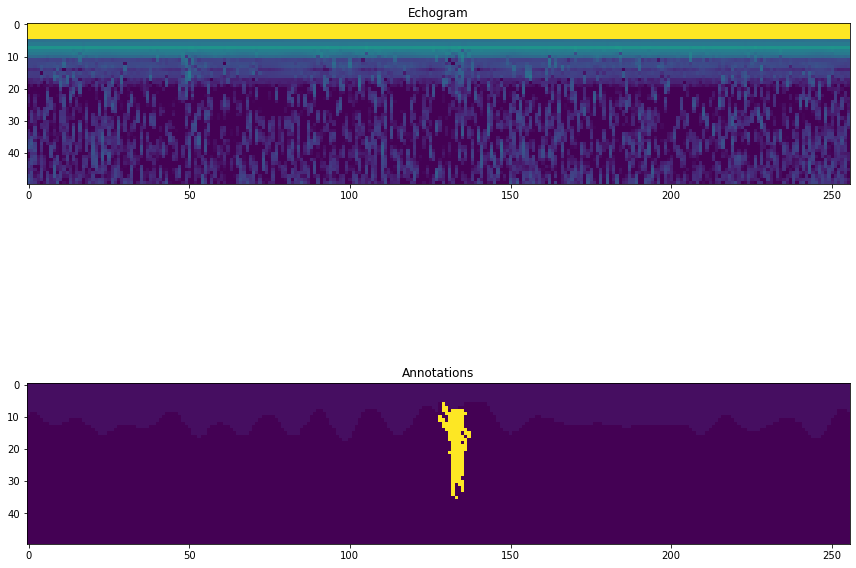

In [8]:
# Upped Depth Index and Upper Dept Contradiction - Nils Olav'a Sorulacak

# !! Only the fish schools at index 3099780, and 3101880 have pixels above 20 threshold

x, y = 3101880, 128 

a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[38000]))
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

thr = 0
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.title('Echogram')
plt.imshow(a[0,:,:].values.T[thr:50,:])
#plt.colorbar()
plt.subplot(2,1,2)
plt.title('Annotations')
plt.imshow(c.T[thr:50,:])
plt.tight_layout()
#plt.colorbar()

plt.show()


# Example Ilustrations before Extracting the Patch Information

mean background Sv = -71.70924  median background Sv = -75.0
mean Sandeel Sv = -63.975594  median background Sv = -66.2623


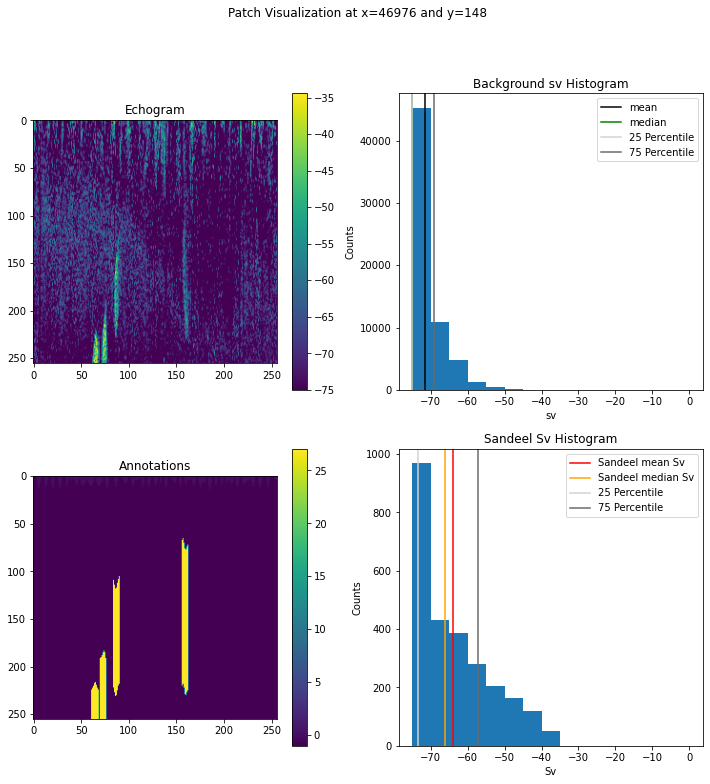

In [9]:
examp_illustr(survey, x=46976, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Creating Coordinates and Metadata Structure

In [10]:
survey = readers[0]

exc_pix_vert = 20 # Vertically excluded pixels

n_pings, n_range = survey.shape

xs = np.arange(patch_size[0] // 2, n_pings - patch_size[0] // 2, patch_size[0])
ys = np.arange(exc_pix_vert + patch_size[1] // 2, patch_size[1] * 3 - patch_size[1] // 2, patch_size[1])

(xs, ys) = np.meshgrid(xs, ys)
coordinate_list = np.array([xs.ravel(), ys.ravel()]).T[:-2,:] # Last two rows excluded

fish_categories = list(survey.fish_categories)


# Producing Metadata for Each Patch Through the Survey Data

In [11]:

# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 2 + 3 + len(survey.fish_categories) + 15))  ## UPDATE EDILECEK

for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    data[i, 0] = x
    data[i, 1] = y

    data_Sv = xr_db_with_limits(survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                                      idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                      return_numpy=False,
                                                      frequencies=[38000]))  # Calculating Sv with limits
    mean_Sv = data_Sv.mean().values
    median_Sv = data_Sv.median(dim=['ping_time', 'range']).values

    data[i, 2] = mean_Sv  # Mean Sv value
    data[i, 3] = median_Sv  # Median Sv value

    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                          idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                          return_numpy=False)
    n_pixels_below_seabed = seabed_mask.sum().values
    data[i, 4] = n_pixels_below_seabed  # Pixels under seabed

    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]

    # Number of Pixels
    data[i, 5] = labels.sel(category=1).sum().values  # Other class
    data[i, 6] = labels.sel(category=27).sum().values  # Sandeel class
    data[i, 7] = labels.sel(category=6009).sum().values  # Possible Sandeel class
    data[i, 8] = 256 * 256 - (data_Sv * data_Sv.isnull()).count().values  # Number of nan pixels
    data[i, 9] = 256 * 256 - (
                data[i, 5] + data[i, 6] + data[i, 7] + data[i, 8])  # Background class (Excluding nan values)

    # Average Intensity Values
    if data[i, 5] != 0: 
        data[i, 10] = ((data_Sv * labels.sel(category=1)).sum() / data[i, 5]).values  # Average Other Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Ot = data_Sv[0].values[labels.sel(category=1) == 1]
        data[i, 14], data[i, 15], data[i, 16] = np.nanstd(sd_Ot), np.percentile(sd_Ot, 25), np.percentile(sd_Ot, 75)
        
    if data[i, 6] != 0: 
        data[i, 11] = ((data_Sv * labels.sel(category=27)).sum() / data[i, 6]).values  # Average Sandeel Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Sd = data_Sv[0].values[labels.sel(category=27) == 1]
        data[i, 17], data[i, 18], data[i, 19] = np.nanstd(sd_Sd), np.nanpercentile(sd_Sd, 25), np.nanpercentile(sd_Sd, 75)
        
    if data[i, 7] != 0: data[i, 12] = (
        (data_Sv * labels.sel(category=6009)).sum() / data[i, 7]).values  # Average Possible Sandeel Sv
    if data[i, 9] == 256 * 256:
        data[i, 13] = mean_Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Bg = data_Sv[0].values
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)
    else:
        sd_Bg = data_Sv[0].values[np.logical_and(labels.sel(category=27).values != 1,
                                                 labels.sel(category=1).values != 1,
                                                 labels.sel(category=6009).values != 1)]
        data[i, 13] = np.nansum(sd_Bg) / data[i, 9]  # Average Background Sv - Excluding nan values
        # Assigning std, 25 percentile and 75 percentile
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)


 27%|██▋       | 8287/31128 [5:43:14<13:17:16,  2.09s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 16233/31128 [11:07:22<13:48:08,  3.34s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 78%|███████▊  | 24320/31128 [18:39:44<6:10:21,  3.26s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

In [13]:
pdata = pd.DataFrame(data)
names = ['x', 'y', 'mean_Sv', 'median_Sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan',
         'nop_background', 'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background',
         'std_other', '25_other', '75_other',
         'std_sandeel', '25_sandeel', '75_sandeel',
        'std_background', '25_background', '75_background']
pdata.columns = names
pdata[pdata['nop_sandeel']>0]

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
156,40064.0,148.0,-73.870842,-75.000000,0.0,4.0,21.0,0.0,0.0,65511.0,...,-73.871510,0.000000,-75.000000,-75.000000,6.667259,-75.000000,-74.839943,3.176561,-75.000000,-75.000000
157,40320.0,148.0,-73.942078,-75.000000,0.0,0.0,553.0,0.0,0.0,64983.0,...,-74.025807,0.000000,0.000000,0.000000,12.859837,-75.000000,-52.035545,3.133881,-75.000000,-75.000000
161,41344.0,148.0,-72.904640,-75.000000,0.0,0.0,199.0,0.0,0.0,65337.0,...,-72.925203,0.000000,0.000000,0.000000,8.498259,-74.903374,-60.133305,4.026905,-75.000000,-72.343742
183,46976.0,148.0,-71.401489,-74.955078,0.0,0.0,2608.0,0.0,0.0,62928.0,...,-71.709247,0.000000,0.000000,0.000000,10.277847,-73.506254,-57.296984,4.808851,-75.000000,-69.268656
187,48000.0,148.0,-72.776779,-75.000000,0.0,0.0,1581.0,0.0,0.0,63955.0,...,-72.934821,0.000000,0.000000,0.000000,8.905481,-75.000000,-60.825806,4.026568,-75.000000,-72.426331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30780,3895168.0,404.0,-64.154984,-65.690063,22997.0,0.0,80.0,74.0,0.0,65382.0,...,-64.230377,0.000000,0.000000,0.000000,5.487714,-65.272139,-57.602351,11.867802,-71.387238,-61.046408
30781,3895424.0,404.0,-64.138306,-65.742516,22409.0,129.0,91.0,21.0,0.0,65295.0,...,-64.168313,6.205171,-67.716026,-58.628769,5.628161,-61.438719,-54.965614,11.902326,-71.227448,-61.160943
30813,3903616.0,404.0,-62.923740,-62.459541,0.0,0.0,1.0,0.0,0.0,65535.0,...,-62.923671,0.000000,0.000000,0.000000,0.000000,-67.699417,-67.699417,5.765183,-66.686737,-58.809919
30890,3923328.0,404.0,-63.102055,-63.707390,2007.0,210.0,48.0,0.0,0.0,65278.0,...,-63.129125,6.727636,-59.655739,-51.597179,8.098677,-65.409256,-53.028552,9.513187,-68.114393,-59.756584


# Saving & Loading the Data

In [146]:
#np.savetxt("Sv_patch_data.csv", data, delimiter=",")
Sv_data = np.loadtxt('Sv_patch_data.csv', delimiter=",")

pdata = pd.DataFrame(Sv_data)
names = ['x', 'y', 'mean_Sv', 'median_Sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan',
         'nop_background', 'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background',
         'std_other', '25_other', '75_other',
         'std_sandeel', '25_sandeel', '75_sandeel',
        'std_background', '25_background', '75_background']
pdata.columns = names
pdata[pdata['nop_sandeel']>=0].head()

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
0,128.0,148.0,-73.024147,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-73.024147,0.0,0.0,0.0,0.0,0.0,0.0,3.740309,-75.0,-72.643904
1,384.0,148.0,-72.961578,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-72.961578,0.0,0.0,0.0,0.0,0.0,0.0,3.817220,-75.0,-72.542253
2,640.0,148.0,-73.257332,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-73.257332,0.0,0.0,0.0,0.0,0.0,0.0,3.570127,-75.0,-73.920282
3,896.0,148.0,-74.101067,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-74.101067,0.0,0.0,0.0,0.0,0.0,0.0,2.439322,-75.0,-75.000000
4,1152.0,148.0,-74.086021,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-74.086021,0.0,0.0,0.0,0.0,0.0,0.0,2.553980,-75.0,-75.000000


# Histogram Plots

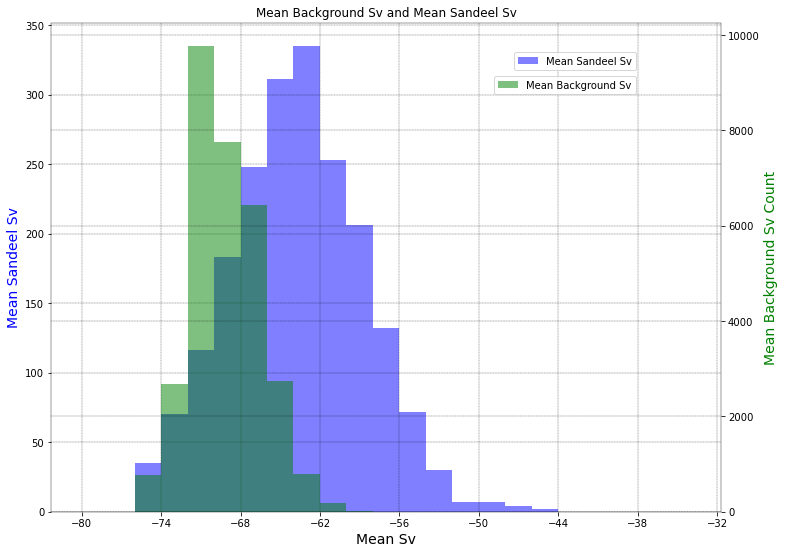

In [189]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

fig_start = -80 # Starting Sv Value of Histogram
fig_finish = -32 # Ending Sv Value of Histogram
s_bin = 2 # Bin size of histogram

bins = np.arange(fig_start, fig_finish, s_bin)


fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Mean Sandeel Sv')
ax.hist(pdata[(pdata['nop_sandeel'] != 0)]['mean_sandeel'], bins = bins,
         label = 'Mean Sandeel Sv', color='blue', alpha=0.5)

ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Mean Sandeel Sv",
              color="blue",
              fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.95))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
ax2=ax.twinx()
ax2.hist(pdata['mean_background'], bins = bins, alpha = 0.5,
         label = 'Mean Background Sv', color='green', log=False)
ax2.set_ylabel("Mean Background Sv Count",
              color="green",
              fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.9))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin*3))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.show()

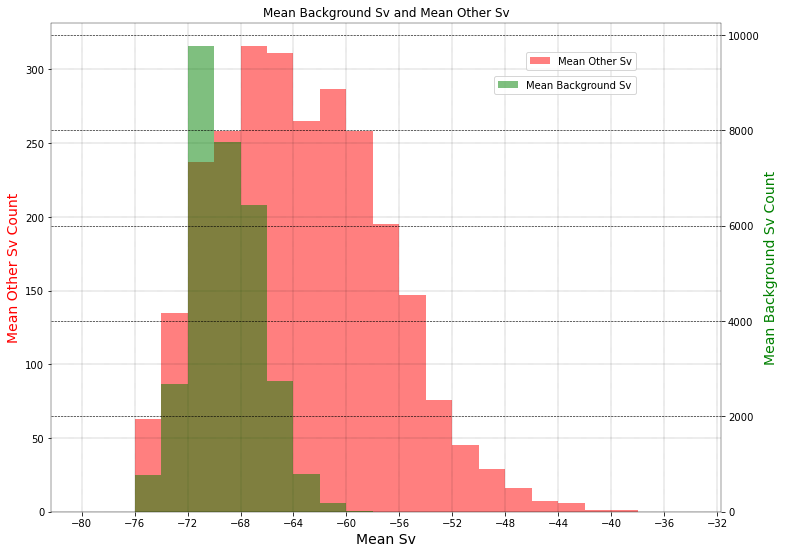

In [188]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

thr_low = -80 # Lower threshold for Mean Sv Background
thr_up = 0 # Upper threshold for Mean Sv Background
fig_start = -80 # Starting Sv Value of Histogram
fig_finish = -32 # Ending Sv Value of Histogram
s_bin = 2 # Bin size of histogram

bins = np.arange(fig_start, fig_finish, s_bin)


fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Mean Other Sv')
ax.hist(pdata[(pdata['nop_other'] != 0)]['mean_other'], bins = bins,
         label = 'Mean Other Sv', color='red', alpha=0.5)

ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Mean Other Sv Count",
              color="red",
              fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.95))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
ax2=ax.twinx()
ax2.hist(pdata['mean_background'], bins = bins, alpha = 0.5,
         label = 'Mean Background Sv', color='green', log=False)
ax2.set_ylabel("Mean Background Sv Count",
              color="green",
              fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.9))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin*2))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.6)
plt.show()

# Patches Containing Sandeel and Other

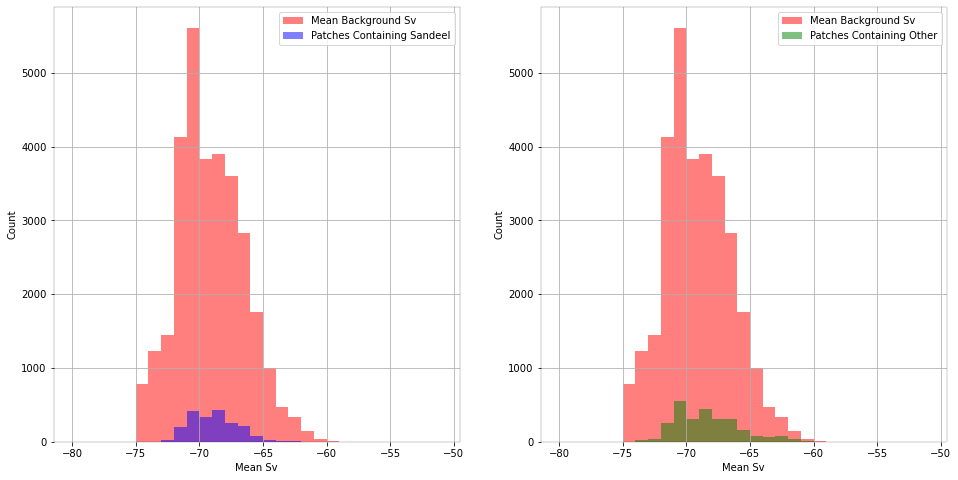

In [212]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(pdata['mean_Sv'], color = 'red', bins = np.arange(-80, -50, 1), alpha = 0.5, label='Mean Background Sv')
plt.hist(pdata[pdata['nop_sandeel']>0]['mean_Sv'], color = 'blue', 
         bins = np.arange(-80, -50, 1), histtype='stepfilled', alpha = 0.5, label='Patches Containing Sandeel')
plt.ylabel('Count')
plt.xlabel('Mean Sv')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.hist(pdata['mean_Sv'], color = 'red', bins = np.arange(-80, -50, 1), alpha = 0.5, label='Mean Background Sv')
plt.hist(pdata[pdata['nop_other']>0]['mean_Sv'], 
         color = 'green', bins = np.arange(-80, -50, 1), 
         alpha = 0.5, histtype='stepfilled', label='Patches Containing Other')
plt.grid()
plt.ylabel('Count')
plt.xlabel('Mean Sv')
plt.legend()
plt.show()

In [184]:
# High Background Pixels (Zooplankton here)
pdata.sort_values(by='mean_background', ascending=False)

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
30553,3837056.0,404.0,-59.274586,-59.499542,19207.0,45.0,0.0,18.0,0.0,65473.0,...,-59.294075,7.923492,-59.948769,-47.972595,0.000000,0.000000,0.000000,11.519003,-65.553562,-55.324493
30568,3840896.0,404.0,-59.725693,-60.361488,18908.0,144.0,0.0,0.0,0.0,65392.0,...,-59.732769,8.823729,-61.998906,-50.211593,0.000000,0.000000,0.000000,11.381167,-65.959726,-55.976132
15385,3938688.0,148.0,-59.747452,-58.577766,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.747452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.740470,-63.431708,-54.886183
15404,3943552.0,148.0,-59.758457,-58.255676,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.758457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.609642,-64.031872,-54.168175
15384,3938432.0,148.0,-59.899563,-58.225815,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.899563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.480749,-63.933967,-54.345251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23604,2058112.0,404.0,-75.000000,-75.000000,0.0,0.0,0.0,0.0,1536.0,64000.0,...,-75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-75.000000,-75.000000
23603,2057856.0,404.0,-75.000000,-75.000000,0.0,0.0,0.0,0.0,1536.0,64000.0,...,-75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-75.000000,-75.000000
23602,2057600.0,404.0,-75.000000,-75.000000,0.0,0.0,0.0,0.0,1536.0,64000.0,...,-75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-75.000000,-75.000000
23591,2054784.0,404.0,-75.000000,-75.000000,0.0,0.0,0.0,0.0,1536.0,64000.0,...,-75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-75.000000,-75.000000


mean background Sv = -59.74745  median background Sv = -58.577766


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


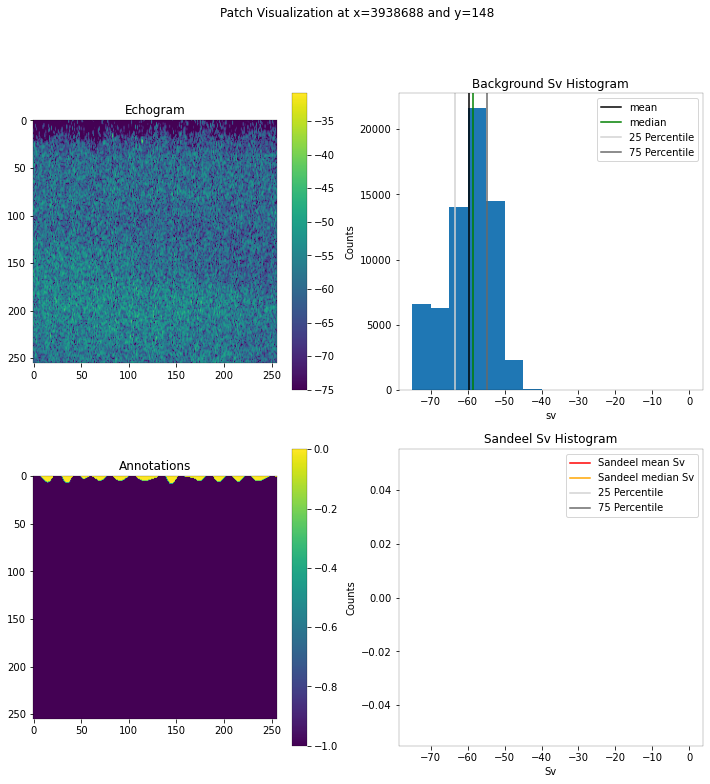

In [183]:
# High Background Values Patch Visualization (max)
max_meanbg = pdata.loc[pdata.idxmax(axis = 0)['mean_background']]['x'].astype('int')
examp_illustr(survey, x=3938688, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Example Ilustrations

mean background sv = nan  median background sv = nan
mean background Sv = nan  median background Sv = nan


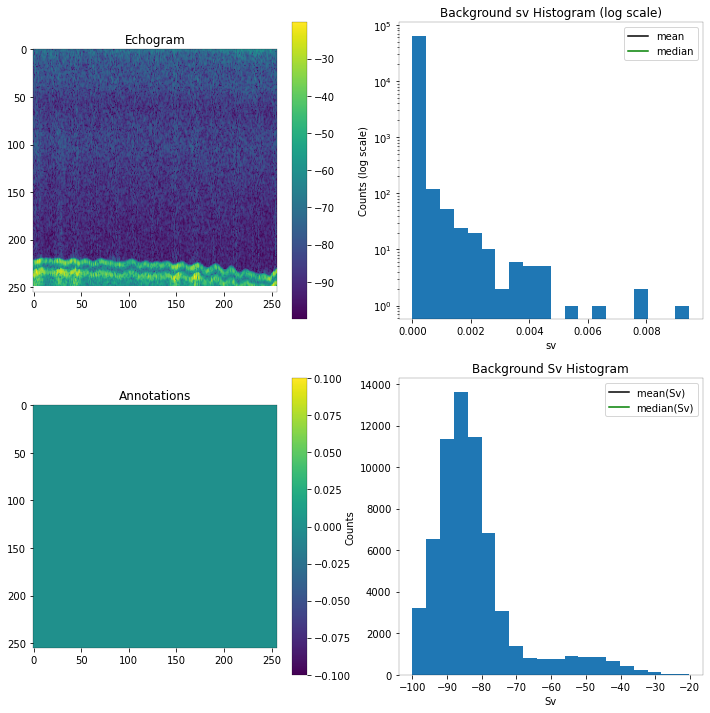

In [71]:
x, y = 560000, 404 

a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[38000])
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)


plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.title('Echogram')
plt.imshow(db(a[0,:,:].values.T))
plt.colorbar()
plt.subplot(2,2,3)
plt.title('Annotations')
plt.imshow(c.T)
plt.colorbar()

plt.subplot(2,2,2)
bg = a[0].values[np.logical_or(c==-1, c==0)]
plt.title('Background sv Histogram (log scale)')
plt.xlabel('sv')
plt.ylabel('Counts (log scale)')
plt.hist(bg, bins = 20, log = True)
plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
plt.axvline(x=np.median(bg), color = 'green', label = 'median')
plt.legend()
print('mean background sv =', bg.mean(), ' median background sv =', np.median(bg))
print('mean background Sv =', db(bg).mean(), ' median background Sv =', np.median(db(bg)))

plt.subplot(2,2,4)
plt.hist(db(bg), bins = 20, log = False)
plt.axvline(x=bg.mean(), color = 'black', label = 'mean(Sv) ')
plt.axvline(x=np.median((bg)), color = 'green', label = 'median(Sv)')

#plt.axvline(x=db(bg.mean()), color = 'red', label = 'Sv(mean)')
#plt.axvline(x=db(np.median(bg)), color = 'blue', label = 'Sv(median)')

plt.title('Background Sv Histogram')
plt.xlabel('Sv')
plt.ylabel('Counts')
plt.legend()
plt.show()


# Summary Patch Information

In [76]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

info = np.array([sb, so, sp, spo, ob, op, pb, b], ndmin = 2)
names = np.array(['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
                      'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg'], ndmin = 2)
info

array([[ 1349,   533,    32,    97,  1854,   169,   102, 26992]])